<a href="https://colab.research.google.com/github/branndonwhite/blossom/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf

# **Data preprocessing**

Data download

In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)
print(data_dir)

/root/.keras/datasets/flower_photos


Slice Dataset

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rotation_range=32,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.1,
#     zoom_range=0.1,
#     fill_mode='nearest',
#     horizontal_flip=True,
#     rescale=1./255,
#     validation_split=0.2
# )

# train_dataset = datagen.flow_from_directory(
#     data_dir,
#     class_mode="categorical",
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     subset="training"
# )

# validation_dataset = datagen.flow_from_directory(
#     data_dir,
#     class_mode="categorical",
#     target_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     subset="validation"
# )

In [ ]:
for image_batch, labels_batch in train_dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

class_names = train_dataset.class_names
print(class_names)

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i+1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

(32, 224, 224, 3)
(32,)
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 19
Number of test batches: 4


Configure dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([                             
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(224, 224, 3)),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(0.15, 0.2),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)                                      
])

# **Create base model from pre-trained model**

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

# **Feature extraction**

Freezing convolutional base

In [ ]:
base_model.trainable = False

Adding classification head

In [ ]:
model = tf.keras.Sequential([
  data_augmentation,
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(5, activation="softmax")
])

In [ ]:
# inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
# x = base_model(x, training=False)
# x = layers.Conv2D(32, 3, activation="relu")(x)
# x = layers.MaxPooling2D(2, 2)(x)
# x = global_average_layer(x)
# x = layers.Dropout(0.2)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)

Compile model

In [ ]:
# base_lr = 0.001 

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

Model Training

In [ ]:
epochs = 10

history = model.fit(
      train_dataset,
      epochs=epochs,
      validation_data=validation_dataset
    )

Epoch 1/10
92/92 [==============================] - 172s 2s/step - loss: 1.3306 - accuracy: 0.4555 - val_loss: 0.5463 - val_accuracy: 0.8201
Epoch 2/10
92/92 [==============================] - 158s 2s/step - loss: 0.6958 - accuracy: 0.7198 - val_loss: 0.4801 - val_accuracy: 0.8432
Epoch 3/10
92/92 [==============================] - 159s 2s/step - loss: 0.6247 - accuracy: 0.7506 - val_loss: 0.4582 - val_accuracy: 0.8449
Epoch 4/10
92/92 [==============================] - 159s 2s/step - loss: 0.5342 - accuracy: 0.7784 - val_loss: 0.4770 - val_accuracy: 0.8366
Epoch 5/10
92/92 [==============================] - 159s 2s/step - loss: 0.5349 - accuracy: 0.7983 - val_loss: 0.3824 - val_accuracy: 0.8713
Epoch 6/10
92/92 [==============================] - 160s 2s/step - loss: 0.5164 - accuracy: 0.8036 - val_loss: 0.3908 - val_accuracy: 0.8564
Epoch 7/10
92/92 [==============================] - 159s 2s/step - loss: 0.4975 - accuracy: 0.8041 - val_loss: 0.4016 - val_accuracy: 0.8515
Epoch 8/10
92

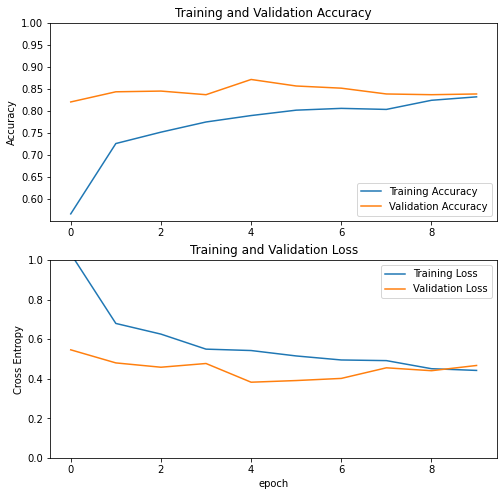

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Fine Tuning**

Unfreeze the top layer

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


Compile the model again

In [ ]:
learning_rate = 0.00001
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy']
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

Continue training the model

In [ ]:
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

history_ft = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset
                       )

Epoch 10/20
92/92 [==============================] - 254s 3s/step - loss: 0.1851 - accuracy: 0.9339 - val_loss: 0.6851 - val_accuracy: 0.8663
Epoch 11/20
92/92 [==============================] - 250s 3s/step - loss: 0.1313 - accuracy: 0.9497 - val_loss: 0.5875 - val_accuracy: 0.8762
Epoch 12/20
92/92 [==============================] - 251s 3s/step - loss: 0.1376 - accuracy: 0.9439 - val_loss: 0.4848 - val_accuracy: 0.8861
Epoch 13/20
92/92 [==============================] - 251s 3s/step - loss: 0.1389 - accuracy: 0.9444 - val_loss: 0.4082 - val_accuracy: 0.9026
Epoch 14/20
92/92 [==============================] - 250s 3s/step - loss: 0.1225 - accuracy: 0.9557 - val_loss: 0.3659 - val_accuracy: 0.9092
Epoch 15/20
92/92 [==============================] - 250s 3s/step - loss: 0.1102 - accuracy: 0.9595 - val_loss: 0.2992 - val_accuracy: 0.9191
Epoch 16/20
92/92 [==============================] - 250s 3s/step - loss: 0.1157 - accuracy: 0.9581 - val_loss: 0.2820 - val_accuracy: 0.9274
Epoch 

In [ ]:
acc += history_ft.history['accuracy']
val_acc += history_ft.history['val_accuracy']

loss += history_ft.history['loss']
val_loss += history_ft.history['val_loss']

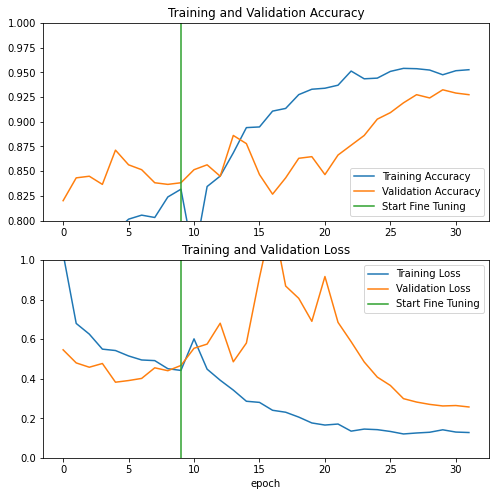

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predict The Image from Test Dataset

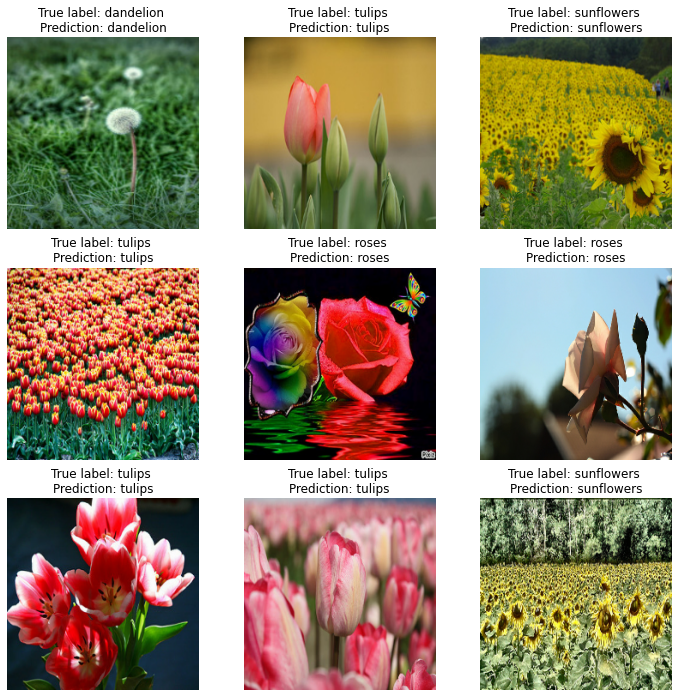

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = predictions.numpy()
predictions_class = []

for pred in predictions:
  predictions_class.append(np.argmax(pred))

# print('Predictions:\n', predictions_class)
# print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title("True label: {} \nPrediction: {}".format(class_names[label_batch[i]], class_names[predictions_class[i]]))
  plt.axis("off")

Predict The Image from Input

Saving test-3.jpg to test-3.jpg
I'm confident 40.46% if this is tulips!


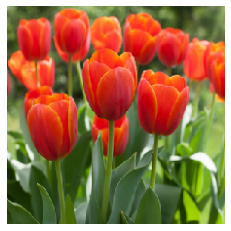

In [ ]:
from google.colab import files

files = files.upload()

for filename in files.keys():
  path = filename
  img = tf.keras.preprocessing.image.load_img(
      path, target_size=(IMG_SIZE)
  )
  plot = plt.imshow(img)
  plt.axis("off")
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print("I'm confident {:.2f}% if this is {}!".format(100 * np.max(score), class_names[np.argmax(score)]))
